### NOTE: must set up GEARS via this repo to run this notebook: https://github.com/yhr91/GEARS_misc

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

import argparse
import sys
sys.path.insert(0, '../../GEARS_misc')

from gears import PertData, GEARS

results_folder = './results/0916_paper/n_obs/'
dataset = 'norman'
data_path = './'
model = 'gears'
device = 'cuda'
seed = 1


def load_data(seed):
    pert_data = PertData(data_path, gene_path='../../data/gears_reproduce/essential_norman.pkl') # specific saved folder
    # pert_data.load(data_path= data_path+dataset) # load the processed data, the path is saved folder + dataset_name
    pert_data.load(data_name = dataset) # load the processed data, the path is saved folder + dataset_name
    pert_data.prepare_split(split = 'simulation', seed = seed)
    pert_data.get_dataloader(batch_size = 32, test_batch_size = 32)
    
    adata_df = pert_data.adata.to_df()
    adata_df['condition'] = pert_data.adata.obs['condition']
    mean_df = adata_df.groupby('condition').mean()
    ctrl_mean = mean_df.loc['ctrl']
    
    return pert_data, ctrl_mean, mean_df

def load_model(pert_data):
    gears_model = GEARS(pert_data, device = 'cuda',
                weight_bias_track = False, 
                proj_name = 'norman', 
                exp_name = 'gears',
                gi_predict = True)
    gears_model.model_initialize(hidden_size = 64,
                                 go_path='./data/go_essential_norman.csv')
    # gears_model.model_initialize(hidden_size = 64)
    return gears_model
    

In [2]:
# pert_data = PertData('../data/gears_reproduce')
# pert_data.load(data_name = 'norman')

In [3]:
pert_data, ctrl_mean, mean_df = load_data(seed)
gears_model = load_model(pert_data)

Found local copy...
Found local copy...
These perturbations are not in the GO graph and is thus not able to make prediction for...
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:43
combo_seen2:19
unseen_single:36
Done!
Creating dataloaders....
Done!


In [4]:
gears_model.train(epochs = 0, lr = 1e-3)

Start Training...
Done!
Start Testing...


Best performing model: Test Top 20 DE MSE: 0.4323
Start doing subgroup analysis for simulation split...
test_combo_seen0_mse: 0.00861961
test_combo_seen0_pearson: 0.9740089463354202
test_combo_seen0_mse_de: 0.35451558
test_combo_seen0_pearson_de: 0.6943848168217962
test_combo_seen1_mse: 0.009928464
test_combo_seen1_pearson: 0.9702276930012425
test_combo_seen1_mse_de: 0.48147526
test_combo_seen1_pearson_de: 0.7319111148370976
test_combo_seen2_mse: 0.0073021366
test_combo_seen2_pearson: 0.9780826741843468
test_combo_seen2_mse_de: 0.60655135
test_combo_seen2_pearson_de: 0.7942141825184494
test_unseen_single_mse: 0.0041696737
test_unseen_single_pearson: 0.9873197976867932
test_unseen_single_mse_de: 0.30105245
test_unseen_single_pearson_de: 0.8470390280114511
test_combo_seen0_pearson_delta: -0.030405572704734676
test_combo_seen0_frac_opposite_direction_top20_non_dropout: 0.5888888888888889
test_combo_seen0_frac_sigma_below_1_non_dropout: 0.5
test_combo_seen0_mse_top20_de_non_dropout: 0.6062

In [5]:
### turn the model on 
model = gears_model.model
model.cell_fitness_pred = True


In [6]:
adata = gears_model.adata
ctrl_adata = adata[adata.obs['condition'] == 'ctrl']

In [7]:
all_pert_list_options = gears_model.pert_list

In [8]:
with open('./data/GI_data.pkl', 'rb') as f:
    fitness_data = pickle.load(f)
    
unique_pert_genes = fitness_data['good_phen'].index.values

from itertools import combinations
pert_list = [i[0] + '+' + i[1] for i in list(combinations(fitness_data['good_phen'].index.values, 2))]

In [9]:
fitness_data['good_phen']['MAML2']['MAML2']

0.0669839569422

In [10]:
fitness_data['fitness_mapper_gene']

{'TSC22D1': -0.08346608425344999,
 'KLF1_MAP2K6': 0.1910113250305,
 'NegCtrl10': nan,
 'CEBPE_RUNX1T1': -0.31674695886575,
 'MAML2': 0.06080807986395001,
 'CEBPE': -0.4039303508675,
 'NegCtrl0': nan,
 'CBL_PTPN9': -0.32823388454924995,
 'TGFBR2_ETS2': -0.10196801640145,
 'SGK1_TBX3': -0.20281957311175,
 'DUSP9': -0.3320538600205,
 'MAP2K6_SPI1': -0.2769397429575,
 'ELMSAN1': 0.0363236090397,
 'UBASH3B_PTPN12': -0.27127366479875004,
 'FOXA1': -0.2326298248365,
 'FOXA3_FOXA1': -0.4693495371825,
 'ETS2_IGDCC3': -0.29297680154775,
 'BCORL1': -0.054614532756199985,
 'MEIS1': -0.12739778786800002,
 'GLB1L2': -0.07379064728580001,
 'KLF1': 0.143951092615,
 'MAP2K6_IKZF3': -0.2537396657525,
 'BAK1': -0.4035843530275001,
 'FEV': -0.168077125293,
 'MAP2K3_SLC38A2': 0.0807590988134975,
 'CBL': -0.121284476273,
 'ETS2': -0.123139654297,
 'SET': -0.180733756213,
 'TBX3': -0.0901566275203,
 'LHX1': -0.1963629441915,
 'KLF1_FOXA1': -0.16398009692675,
 'TBX3_TBX2': -0.142577028222,
 'SLC4A1': -0.40324

In [11]:
with open('./data/GI_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [12]:
class GI_expt():
    # TODO get rid of hold out genes
    def __init__(self, raw=False, pick_genes = None, set_train = None):
        # sample: matrix sampling percentage
        # seed: sampling seed,
        # sampled_data: sampled indices from upper traingle matrix
        # test: matrix values to be predicted
        # train: observed matrix values used for training, 
        # delta: deviation from expectation as inferred using 
        #        a regression model trained on sampled_data (corresponds to sampled_data)
        # delta_tot: delta values computed for all matrix values
        # y_tot: Full true matrix (raw fitness values)
        # raws: Sampled raw fitness values (corresponds to sampled_data)
        # transformer: regression model used to determine expected fitness values
        

        with open('./data/GI_data.pkl', 'rb') as f:
            self.data = pickle.load(f)
        self.raw = raw
        self.pick_genes = pick_genes
        self.set_train = set_train

    def pre_process(self, sample, seed):
        itr_data = {}
        itr_data['sample'] = sample
        itr_data['seed'] = seed

        # Randomly sample from the fitness matrix
        if self.set_train is not None:
            itr_data['sampled_data'] = self.set_train
        elif self.pick_genes is None:
            itr_data['sampled_data'] = \
               upper_triangle(self.data['good_phen'], k=0).sample(
               frac=float(sample) / 100., replace=False, random_state=seed).index
        else:
            itr_data['sampled_data'] = \
                upper_triangle(self.data['good_phen'].iloc[self.pick_genes,
                                                    self.pick_genes]).index

        # Set up masked delta matrix for performing matrix completion
        itr_data['delta'], itr_data['test'], \
        itr_data['train'], itr_data['delta_tot'], \
        itr_data['X_tot'], itr_data['y_tot'], itr_data['transformer'], \
        itr_data['raws'] = \
            get_masked_delta_matrix(self.data['good_phen'],
                                    itr_data['sampled_data'],
                                    self.data['fitness_mapper_gene'],
                                    self.data['good_genes'])

        return itr_data


def get_masked_delta_matrix(data, sampling, phen_mapper, good_genes):
    masked_data, mask = get_masked_data(data, sampling)

    upper_masked_data = upper_triangle(masked_data)
    predicted = upper_masked_data[upper_masked_data == 0].index
    given = upper_masked_data[upper_masked_data != 0].index

    delta_tot, X, X_tot, y, y_tot, transformer, raws = get_deltas(data, masked_data, phen_mapper, good_genes)
    delta, _ = get_masked_data(delta_tot, sampling)
    raws, _ = get_masked_data(raws, sampling)

    return delta, predicted, given, delta_tot, X_tot, y_tot, transformer, raws

def get_deltas(source_data, sampled_data, phen_mapper, good_genes):
    # this is the routine that fits a quadratic model to observed fitness measurements and returns
    # the deviations from the expectation given by that model (the "deltas")
    y = sampled_data.stack()
    y = y[y != 0]

    X = np.concatenate([y.index.get_level_values(0).map(lambda x: phen_mapper[x]).values[:, np.newaxis],
                        y.index.get_level_values(1).map(lambda x: phen_mapper[x]).values[:, np.newaxis]], axis=1)

    y_tot = source_data.loc[good_genes, good_genes].stack()
    X_tot = np.concatenate([y_tot.index.get_level_values(0).map(lambda x: phen_mapper[x]).values[:, np.newaxis],
                            y_tot.index.get_level_values(1).map(lambda x: phen_mapper[x]).values[:, np.newaxis]],
                           axis=1)

    transformer = PolynomialFeatures()
    model = make_pipeline(PolynomialFeatures(), LinearRegression())
    model.fit(X, y)

    delta = pd.Series(y_tot - model.predict(X_tot), index=y_tot.index)
    raws = pd.Series(y_tot, index=y_tot.index).unstack()
    delta = delta.unstack()

    return delta, X, X_tot, y, y_tot, model, raws

def upper_triangle(M, k=1):
    """ Copyright (C) 2019  Thomas Norman
    Return the upper triangular part of a matrix in stacked format (i.e. as a vector)
    """
    keep = np.triu(np.ones(M.shape), k=k).astype('bool').reshape(M.size)
    return M.stack(dropna=False).loc[keep]

def get_masked_data(df, ind, mean_normalize=False):
    masked_data = df.copy().values
    mask = pd.DataFrame(0, index=df.index, columns=df.columns)

    for gene1, gene2 in ind:
        # only include genes present in df
        if gene1 in mask.index and gene2 in mask.columns:
            mask.loc[gene1, gene2] = 1

        # assume DataFrame is symmetric
    mask = mask + mask.T
    mask = (mask != 0).values
    masked_data[~mask] = 0
    masked_data_df = pd.DataFrame(masked_data, index=df.index, columns=df.columns)

    # whether to center the observed entries such that the overall mean is 0
    if mean_normalize:
        masked_data_df = masked_data_df.stack()
        offset = masked_data_df[masked_data_df != 0]
        offset = offset.mean()
        masked_data_df[masked_data_df != 0] = masked_data_df[masked_data_df != 0] - offset
        print(offset)
        masked_data_df = masked_data_df.unstack()

    return masked_data_df, mask

In [13]:
# load train gene split used for in-house models 
# train_split = pd.read_csv('../../data/pert_norman_data_splits/norman_train_split.csv')
# train_genes = pd.MultiIndex.from_tuples(zip(train_split['Gene1'], train_split['Gene2']))

In [14]:
# Run prediction
from torch_geometric.data import DataLoader

import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from copy import deepcopy

def evaluate(model, loader):
    model.eval()
    y_all = []
    loss_all = []
    pert_all = []
    y_true_all = []
    for step, batch in enumerate(tqdm(loader)):
        batch = batch.to(device)
        out, y_pred = model(batch)
        loss = loss_fct(batch.y.reshape(-1), y_pred.reshape(-1))
        loss_all.append(loss.item())
        y_all.append(y_pred.detach().cpu().numpy())
        pert_all.append(batch.pert)
        y_true_all.append(batch.y)
    return y_all, loss_all, pert_all, y_true_all

def get_dataloader(set2cond, batch_size, test_batch_size = None):
    if test_batch_size is None:
        test_batch_size = batch_size

    cell_graphs = {}
    

    splits = ['train','val','test']
    for i in splits:
        cell_graphs[i] = []
        for p in set2cond[i]:
            if p in all_cell_graphs:
                cell_graphs[i].extend(all_cell_graphs[p])

    # Set up dataloaders
    train_loader = DataLoader(cell_graphs['train'],
                        batch_size=batch_size, shuffle=True, drop_last = True)
    val_loader = DataLoader(cell_graphs['val'],
                        batch_size=batch_size, shuffle=True)

    test_loader = DataLoader(cell_graphs['test'],
                    batch_size=batch_size, shuffle=False)
    return {'train_loader': train_loader,
                        'val_loader': val_loader,
                        'test_loader': test_loader}

# for sample_frac in [40, 50, 60]:
n_train = 4278
n_samples = [100, 200, 350, 500, 750, 1000, 1250, 1500]
for seed in [123, 847, 618]:
    for n_sample in n_samples:
        sample_frac = float(n_sample) / float(n_train) * 100
        # for label in ['delta_tot', 'raw_y']:
        for label in ['raw_y']:

            # GI = GI_expt(set_train = train_genes)
            GI = GI_expt(pick_genes=None)
            itr_data = GI.pre_process(sample=sample_frac, seed=seed)

            itr_data['raw_y'] = fitness_data['good_phen']
            y = itr_data[label].values

            gene2idx = dict(zip(itr_data[label].index.values, range(len(itr_data[label].index.values))))

            pert_list = [i[0] + '+' + i[1] for i in list(combinations(itr_data[label].index.values, 2))]
            pert_list += [i + '+ctrl' for i in unique_pert_genes]

            y_list = []
            for i in pert_list:
                if i.split('+')[1]!= 'ctrl':
                    y_list.append(y[gene2idx[i.split('+')[0]], gene2idx[i.split('+')[1]]])
                else:
                    y_list.append(y[gene2idx[i.split('+')[0]], gene2idx[i.split('+')[0]]])

            pert_list2y_list = dict(zip(pert_list, y_list))

            train = [i[0] + '+' + i[1] for i in itr_data['train']]
            test = [i[0] + '+' + i[1] for i in itr_data['test']]

            from sklearn.model_selection import train_test_split
            train, val, _, _ = train_test_split(train, [-1] * len(train), test_size=0.1, random_state=seed)

            ## add single back
            train = train + [i + '+ctrl' for i in unique_pert_genes]

            set2cond = {
                'train': train,
                'val': val,
                'test': test
            }

            from torch_geometric.data import Data
            import torch
            from tqdm import tqdm
            num_samples = 20
            all_cell_graphs = {}
            pert_na = []
            for pert in tqdm(pert_list):
                pert_name = pert
                pert = pert.split('+')
                pert = [i for i in pert if i!='ctrl']

                # Get the indices (and signs) of applied perturbation
                try:
                    pert_idx = [np.where(p == np.array(all_pert_list_options))[0][0] for p in pert]
                    Xs = ctrl_adata[np.random.randint(0, len(ctrl_adata), num_samples), :].X.toarray()
                    # Create cell graphs
                    all_cell_graphs[pert_name] = [Data(x=torch.Tensor(X).T, pert_idx = pert_idx, pert=pert, y=pert_list2y_list[pert_name]) for X in Xs]
                except:
                    pert_na.append(pert_name)

            loaders = get_dataloader(set2cond, batch_size = 32)
            train_loader = loaders['train_loader']
            val_loader = loaders['val_loader']
            test_loader = loaders['test_loader']

            optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay = 5e-4)
            scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

            loss_fct = F.mse_loss
            earlystop_validation_metric = 'mse'
            binary_output = False

            earlystop_direction = 'descend'
            min_val = np.inf

            best_model = deepcopy(model).to(device)

            loss_history = {
                'loss': []
            }

            print('Start Training...')
            for epoch in range(1):
                model.train()

                for step, batch in enumerate(tqdm(train_loader)):
                    optimizer.zero_grad()
                    batch = batch.to(device)
                    out, y_pred = model(batch)
                    loss = loss_fct(batch.y.float().reshape(-1), y_pred.reshape(-1))
                    loss.backward()
                    optimizer.step()
                    loss_history['loss'].append(loss.item())

                    if (step % 200 == 0) and (step >= 200):
                        log = "Epoch {} Step {} Train Loss: {:.4f}" 
                        print(log.format(epoch + 1, step + 1, loss.item()))
                #_, val_loss
                val_y_all, val_loss_all, val_pert_all, val_y_true_all = evaluate(model, val_loader)
                if np.mean(val_loss_all) < min_val:
                    best_model = deepcopy(model)
                    min_val = np.mean(val_loss_all)
            test_y_all, test_loss_all, test_pert_all, test_y_true_all = evaluate(best_model, test_loader)
            print(np.mean(test_loss_all))


            pert_test_list = [i[0] + '+' +  i[1] if len(i) == 2 else i[0] +'+ctrl' for i in [j for i in test_pert_all for j in i]]
            test_y_list = np.concatenate([i for i in [j for i in test_y_all for j in i]])
            test_y_true_list = np.concatenate([i.detach().cpu().numpy() for i in test_y_true_all])
            df_pred = pd.DataFrame((pert_test_list, test_y_true_list, test_y_list)).T
            pert2y_true = dict(df_pred.groupby([0])[1].agg(np.mean))
            pert2y_pred = dict(df_pred.groupby([0])[2].agg(np.mean))

            pred = pd.DataFrame(pert2y_true, index = [0]).T.reset_index().rename(columns = {0: 'truth', 'index': 'test_pert'})
            pred['pred'] = pred.test_pert.apply(lambda x: pert2y_pred[x])
            pred.to_csv(results_folder + label + '_pred_no_pretrain_update_seed' + str(seed) + '_nsample' + str(n_sample) + 'norman.csv', index = False)
            # pred.to_csv(label + '_pred_no_pretrain_update_' + str(seed) + '_' + str(sample_frac) + '_neptunesplit.csv', index = False)

100%|██████████| 4278/4278 [00:23<00:00, 178.32it/s]


Start Training...


100%|██████████| 2334/2334 [02:23<00:00, 16.27it/s]


0.3716477405523399


100%|██████████| 4278/4278 [00:24<00:00, 176.02it/s]


Start Training...


100%|██████████| 2280/2280 [02:08<00:00, 17.73it/s]


0.07388217964964612


100%|██████████| 4278/4278 [00:24<00:00, 175.03it/s]


Start Training...


 87%|████████▋ | 202/231 [00:28<00:04,  6.86it/s]

Epoch 1 Step 201 Train Loss: 0.1671


100%|██████████| 2196/2196 [02:00<00:00, 18.25it/s]


0.13647683805746386


100%|██████████| 4278/4278 [00:22<00:00, 186.60it/s]


Start Training...


 66%|██████▌   | 202/305 [00:32<00:14,  6.95it/s]

Epoch 1 Step 201 Train Loss: 0.0411


100%|██████████| 2114/2114 [01:58<00:00, 17.83it/s]


0.0431070358138228


100%|██████████| 4278/4278 [00:23<00:00, 183.67it/s]


Start Training...


 47%|████▋     | 201/425 [00:34<00:39,  5.73it/s]

Epoch 1 Step 201 Train Loss: 0.0025


 95%|█████████▍| 402/425 [01:08<00:03,  6.23it/s]

Epoch 1 Step 401 Train Loss: 0.0028


100%|██████████| 1978/1978 [01:59<00:00, 16.56it/s]


0.11286700005390919


100%|██████████| 4278/4278 [00:23<00:00, 183.90it/s]


Start Training...


 37%|███▋      | 202/551 [00:25<00:43,  7.99it/s]

Epoch 1 Step 201 Train Loss: 0.0033


 73%|███████▎  | 402/551 [00:59<00:24,  6.00it/s]

Epoch 1 Step 401 Train Loss: 0.0060


100%|██████████| 1840/1840 [02:04<00:00, 14.78it/s]


0.028627431005566806


100%|██████████| 4278/4278 [00:23<00:00, 184.25it/s]


Start Training...


 30%|██▉       | 202/676 [00:28<01:08,  6.94it/s]

Epoch 1 Step 201 Train Loss: 0.0038


 59%|█████▉    | 402/676 [00:56<00:32,  8.44it/s]

Epoch 1 Step 401 Train Loss: 0.0067


 89%|████████▉ | 602/676 [01:21<00:09,  7.66it/s]

Epoch 1 Step 601 Train Loss: 0.0028


100%|██████████| 1700/1700 [01:36<00:00, 17.58it/s]


0.01526049331711069


100%|██████████| 4278/4278 [00:23<00:00, 184.33it/s]


Start Training...


 25%|██▌       | 202/806 [00:31<01:30,  6.65it/s]

Epoch 1 Step 201 Train Loss: 0.0086


 50%|████▉     | 402/806 [00:58<00:47,  8.44it/s]

Epoch 1 Step 401 Train Loss: 0.0040


 75%|███████▍  | 602/806 [01:23<00:24,  8.33it/s]

Epoch 1 Step 601 Train Loss: 0.0013


100%|█████████▉| 802/806 [01:47<00:00,  8.88it/s]

Epoch 1 Step 801 Train Loss: 0.0021


100%|██████████| 1561/1561 [01:29<00:00, 17.48it/s]


0.015507540074182874


100%|██████████| 4278/4278 [00:23<00:00, 183.27it/s]


Start Training...


100%|██████████| 2337/2337 [02:38<00:00, 14.74it/s]


0.010803047745543535


100%|██████████| 4278/4278 [00:23<00:00, 183.96it/s]


Start Training...


100%|██████████| 2282/2282 [02:30<00:00, 15.15it/s]


0.006622658085375286


100%|██████████| 4278/4278 [00:22<00:00, 186.47it/s]


Start Training...


 88%|████████▊ | 202/230 [00:33<00:04,  6.03it/s]

Epoch 1 Step 201 Train Loss: 0.0029


100%|██████████| 2198/2198 [02:15<00:00, 16.26it/s]


0.07650427686873973


100%|██████████| 4278/4278 [00:25<00:00, 170.40it/s]


Start Training...


 66%|██████▌   | 202/306 [00:26<00:13,  7.59it/s]

Epoch 1 Step 201 Train Loss: 0.0039


100%|██████████| 2113/2113 [02:55<00:00, 12.01it/s]


0.011045461451448404


100%|██████████| 4278/4278 [00:23<00:00, 182.53it/s]


Start Training...


 47%|████▋     | 202/429 [00:25<00:29,  7.73it/s]

Epoch 1 Step 201 Train Loss: 0.0021


 94%|█████████▎| 402/429 [00:51<00:03,  8.28it/s]

Epoch 1 Step 401 Train Loss: 0.0023


100%|██████████| 1975/1975 [02:14<00:00, 14.73it/s]


0.014424346249830926


100%|██████████| 4278/4278 [00:23<00:00, 183.06it/s]


Start Training...


 36%|███▋      | 202/555 [00:19<00:35,  9.91it/s]

Epoch 1 Step 201 Train Loss: 0.0042


 72%|███████▏  | 401/555 [00:39<00:15, 10.25it/s]

Epoch 1 Step 401 Train Loss: 0.0039


100%|██████████| 1836/1836 [01:08<00:00, 26.73it/s]


0.002827929382840464


100%|██████████| 4278/4278 [00:23<00:00, 183.56it/s]


Start Training...


 30%|██▉       | 201/680 [00:21<00:46, 10.35it/s]

Epoch 1 Step 201 Train Loss: 0.0039


 59%|█████▉    | 403/680 [00:40<00:27, 10.20it/s]

Epoch 1 Step 401 Train Loss: 0.0053


 89%|████████▊ | 602/680 [01:00<00:07, 10.11it/s]

Epoch 1 Step 601 Train Loss: 0.0060


100%|██████████| 1697/1697 [00:51<00:00, 32.66it/s]


0.03509370836878724


100%|██████████| 4278/4278 [00:23<00:00, 184.33it/s]


Start Training...


 25%|██▌       | 202/807 [00:22<01:07,  8.99it/s]

Epoch 1 Step 201 Train Loss: 0.0038


 50%|████▉     | 402/807 [00:43<00:42,  9.46it/s]

Epoch 1 Step 401 Train Loss: 0.0065


 75%|███████▍  | 602/807 [01:04<00:20,  9.87it/s]

Epoch 1 Step 601 Train Loss: 0.0039


 99%|█████████▉| 802/807 [01:25<00:00,  8.05it/s]

Epoch 1 Step 801 Train Loss: 0.0027


100%|██████████| 1557/1557 [00:58<00:00, 26.73it/s]


0.0030542000265656568


100%|██████████| 4278/4278 [00:23<00:00, 185.02it/s]


Start Training...


100%|██████████| 2342/2342 [01:00<00:00, 38.81it/s]


0.026231275686893072


100%|██████████| 4278/4278 [00:23<00:00, 183.36it/s]


Start Training...


100%|██████████| 2285/2285 [01:32<00:00, 24.71it/s]


0.0039994111654917


100%|██████████| 4278/4278 [00:23<00:00, 183.99it/s]


Start Training...


 89%|████████▉ | 202/226 [00:17<00:02, 10.07it/s]

Epoch 1 Step 201 Train Loss: 0.0016


100%|██████████| 2201/2201 [01:16<00:00, 28.77it/s]


0.003217691437183711


100%|██████████| 4278/4278 [00:23<00:00, 183.51it/s]


Start Training...


 67%|██████▋   | 202/303 [00:22<00:09, 10.17it/s]

Epoch 1 Step 201 Train Loss: 0.0050


100%|██████████| 2117/2117 [01:00<00:00, 34.84it/s]


0.01886939649745382


100%|██████████| 4278/4278 [00:25<00:00, 169.16it/s]


Start Training...


 47%|████▋     | 202/428 [00:20<00:22, 10.02it/s]

Epoch 1 Step 201 Train Loss: 0.0018


 94%|█████████▍| 402/428 [00:40<00:02, 10.22it/s]

Epoch 1 Step 401 Train Loss: 0.0047


100%|██████████| 1977/1977 [01:18<00:00, 25.18it/s]


0.004107563145632759


100%|██████████| 4278/4278 [00:23<00:00, 182.04it/s]


Start Training...


 36%|███▋      | 203/560 [00:21<00:34, 10.22it/s]

Epoch 1 Step 201 Train Loss: 0.0022


 72%|███████▏  | 402/560 [00:40<00:15, 10.48it/s]

Epoch 1 Step 401 Train Loss: 0.0022


100%|██████████| 1834/1834 [01:01<00:00, 30.02it/s]


0.003604601030127456


100%|██████████| 4278/4278 [00:23<00:00, 182.06it/s]


Start Training...


 29%|██▉       | 202/686 [00:20<00:48, 10.00it/s]

Epoch 1 Step 201 Train Loss: 0.0019


 58%|█████▊    | 401/686 [00:39<00:28, 10.14it/s]

Epoch 1 Step 401 Train Loss: 0.0045


 88%|████████▊ | 602/686 [01:05<00:12,  6.90it/s]

Epoch 1 Step 601 Train Loss: 0.0023


100%|██████████| 1692/1692 [01:10<00:00, 24.15it/s]


0.006433559187904667


100%|██████████| 4278/4278 [00:23<00:00, 181.74it/s]


Start Training...


 25%|██▌       | 202/805 [00:16<00:50, 12.02it/s]

Epoch 1 Step 201 Train Loss: 0.0049


 50%|████▉     | 402/805 [00:35<00:39, 10.21it/s]

Epoch 1 Step 401 Train Loss: 0.0036


 75%|███████▍  | 602/805 [00:55<00:19, 10.45it/s]

Epoch 1 Step 601 Train Loss: 0.0053


100%|█████████▉| 803/805 [01:16<00:00,  9.64it/s]

Epoch 1 Step 801 Train Loss: 0.0028


100%|██████████| 1556/1556 [00:45<00:00, 34.20it/s]


0.009747359509842663


### Plotting results

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
font = {'size'   : 16}

matplotlib.rc('font', **font)
from scipy.stats import pearsonr

In [16]:
sampling_rate = 1
pred_ = pd.read_csv('raw_y_pred_no_pretrain_update_1_'+str(sampling_rate)+'_rep2.csv')
# pred_ = pd.read_csv('raw_y_pred_no_pretrain_update_1_'+str(sampling_rate)+'_neptunesplit.csv')
sns.scatterplot(x=pred_['truth'], y=pred_['pred'], s = 4, edgecolor='royalblue', color='royalblue')

plot_min = pred_.iloc[:,1:].values.min()
plot_max = pred_.iloc[:,1:].values.max()

plt.plot([plot_min,plot_max],[plot_min,plot_max],color='black', linestyle='--')
plt.ylabel('Predicted Cell Fitness')
plt.xlabel('True Cell Fitness')

r_2 = pearsonr(pred_['truth'], pred_['pred'])[0]**2
plt.text(-0.75, 0.1, r"$R^2=$"+str(round(r_2,3)))

plt.title('Sampling rate: '+str(sampling_rate) +'%', fontsize=16)
plt.savefig('Norman_fitness_'+str(sampling_rate)+'.pdf',dpi=200, bbox_inches = "tight")

print('MSE: ' + str(np.sum((pred_['truth'] - pred_['pred'])**2) / pred_.shape[0]))

FileNotFoundError: [Errno 2] No such file or directory: 'raw_y_pred_no_pretrain_update_1_1_rep2.csv'

MSE: 0.007000032147680486


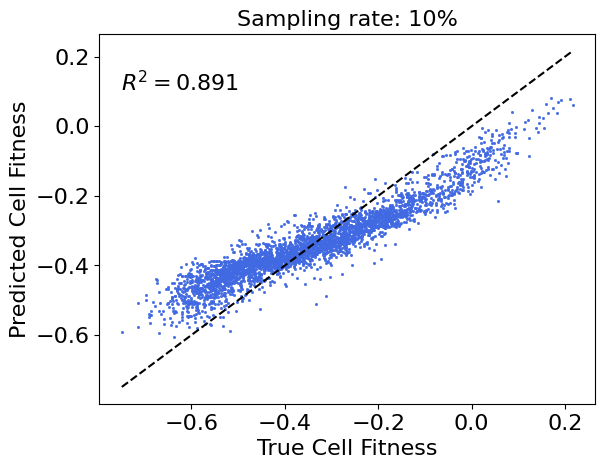

In [16]:
sampling_rate = 10
pred_ = pd.read_csv('raw_y_pred_no_pretrain_update_1_'+str(sampling_rate)+'_rep2.csv')
# pred_ = pd.read_csv('raw_y_pred_no_pretrain_update_1_'+str(sampling_rate)+'_neptunesplit.csv')
sns.scatterplot(x=pred_['truth'], y=pred_['pred'], s = 4,  edgecolor='royalblue', color='royalblue')

plot_min = pred_.iloc[:,1:].values.min()
plot_max = pred_.iloc[:,1:].values.max()

plt.plot([plot_min,plot_max],[plot_min,plot_max],color='black', linestyle='--')
plt.ylabel('Predicted Cell Fitness')
plt.xlabel('True Cell Fitness')

r_2 = pearsonr(pred_['truth'], pred_['pred'])[0]**2
plt.text(-0.75, 0.1, r"$R^2=$"+str(round(r_2,3)))

plt.title('Sampling rate: '+str(sampling_rate) +'%', fontsize=16)
plt.savefig('Norman_fitness_'+str(sampling_rate)+'.pdf',dpi=200, bbox_inches = "tight")

print('MSE: ' + str(np.sum((pred_['truth'] - pred_['pred'])**2) / pred_.shape[0]))

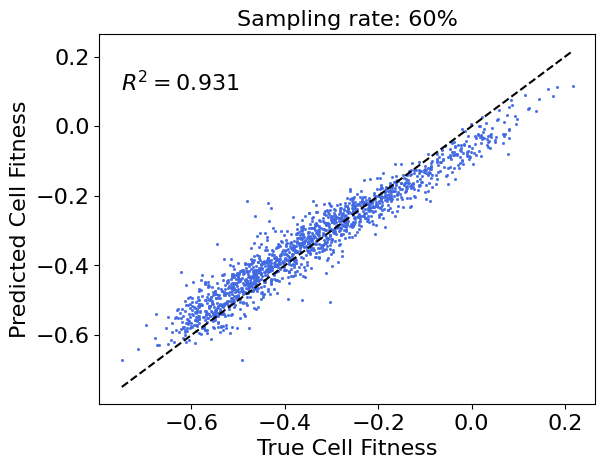

In [17]:
sampling_rate = 60
pred_ = pd.read_csv('raw_y_pred_no_pretrain_update_1_'+str(sampling_rate)+'_rep2.csv')
# pred_ = pd.read_csv('raw_y_pred_no_pretrain_update_1_'+str(sampling_rate)+'_neptunesplit.csv')
sns.scatterplot(x=pred_['truth'], y=pred_['pred'], s = 4, edgecolor='royalblue', color='royalblue')

plot_min = pred_.iloc[:,1:].values.min()
plot_max = pred_.iloc[:,1:].values.max()

plt.plot([plot_min,plot_max],[plot_min,plot_max],color='black', linestyle='--')
plt.ylabel('Predicted Cell Fitness')
plt.xlabel('True Cell Fitness')

r_2 = pearsonr(pred_['truth'], pred_['pred'])[0]**2
plt.text(-0.75, 0.1, r"$R^2=$"+str(round(r_2,3)))

plt.title('Sampling rate: '+str(sampling_rate) +'%', fontsize=16)
plt.savefig('Norman_fitness_'+str(sampling_rate)+'.pdf',dpi=200, bbox_inches = "tight")